state reset: 0
observation space: 16
state one hot: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
state: 0
state one hot xxxxx: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
observation space: 16
state one hot: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
state: 0
state one hot xxxxx: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
observation space: 16
state one hot: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
state: 0
state one hot xxxxx: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
observation space: 16
state one hot: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
state: 4
state one hot xxxxx: tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
observation space: 16
state one hot: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
state

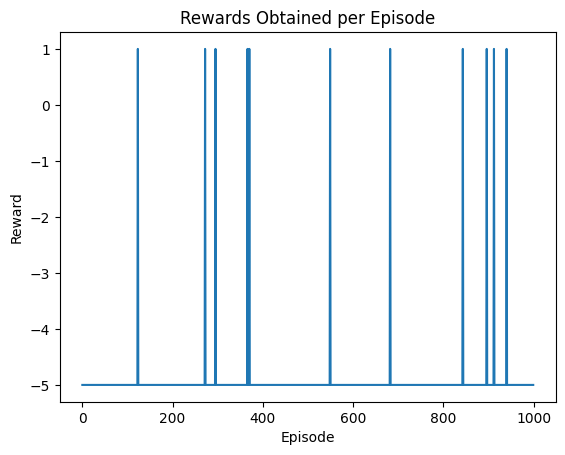

Success rate: 1.10%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.envs.registration import register
import random
from collections import deque
import matplotlib.pyplot as plt

# Register the custom FrozenLake environment
register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=1000000000,
    reward_threshold=0.78,  # Adjust the reward threshold if needed
)

# Define the custom FrozenLake environment with modified rewards
class CustomRewardFrozenLake(gym.Env):
    def __init__(self):
        self.env = gym.make("CustomRewardFrozenLake-v1")
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if reward == 0 and not done:
            reward = 0
        elif reward == 0 and done:
            reward = -5
        elif reward == 1:
            reward = 1
        return state, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

# Define Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Define Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Experience Buffer
class ExperienceBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, log_prob, value, reward, done):
        self.buffer.append((state, action, log_prob, value, reward, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, log_probs, values, rewards, dones = zip(*batch)
        return states, actions, log_probs, values, rewards, dones

# Define Proximal Policy Optimization (PPO) class
class PPO:
    def __init__(self, actor, critic, actor_optimizer, critic_optimizer):
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer

    def calculate_ppo_loss(self, states, actions, log_probs_old, values_old, advantages, epsilon=0.2, c1=0.5, c2=0.01):
        policy = self.actor(states)
        dist = torch.distributions.Categorical(policy)

        log_probs = dist.log_prob(actions)
        ratios = torch.exp(log_probs - log_probs_old)
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1.0 - epsilon, 1.0 + epsilon) * advantages

        actor_loss = -torch.min(surr1, surr2).mean()

        values = self.critic(states)
        critic_loss = (values - values_old).pow(2).mean()

        entropy = dist.entropy().mean()

        total_loss = actor_loss + c1 * critic_loss - c2 * entropy

        return actor_loss, critic_loss, total_loss

    def update(self, states, actions, log_probs_old, values_old, advantages):
        actor_loss, critic_loss, total_loss = self.calculate_ppo_loss(states, actions, log_probs_old, values_old, advantages)

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        total_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item(), total_loss.item()

# Display Class for plotting
class Display:
    @staticmethod
    def plot_rewards(episode_rewards):
        plt.plot(episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Rewards Obtained per Episode')
        plt.show()

# Discounted rewards function
def discount_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

# Function to compute advantages
def compute_advantages(critic, states, rewards):
    values = critic(states).squeeze()
    advantages = rewards - values
    return advantages

# Function to train the agent
def train_agent(env, actor, critic, actor_optimizer, critic_optimizer, num_episodes=1000):
    buffer_size = 1000000
    experience_buffer = ExperienceBuffer(buffer_size)
    success_count = 0
    episode_rewards = []

    ppo_agent = PPO(actor, critic, actor_optimizer, critic_optimizer)

    for episode in range(num_episodes):
        state = env.reset()
        print(f"state reset: {state}")
        episode_reward = 0
        success = False

        states = []
        actions = []
        log_probs = []
        values = []
        rewards = []

        while True:
            state_one_hot = torch.zeros(1, env.observation_space.n)
            print(f"observation space: {env.observation_space.n}")
            # print(f"state one hot: {state_one_hot}")
            print(f"state: {state}")
            state_one_hot[0, state] = 1
            print(f"state one hot xxxxx: {state_one_hot}")
            states.append(state_one_hot)

            policy = actor(state_one_hot)
            dist = torch.distributions.Categorical(policy)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            actions.append(action.item())
            log_probs.append(log_prob)
            value = critic(state_one_hot)
            values.append(value.item())

            next_state, reward, done, _ = env.step(action.item())
            rewards.append(reward)
            episode_reward += reward

            experience_buffer.add(state_one_hot, action, log_prob, value, reward, done)

            state = next_state

            if done:
                success = reward == 1
                if success:
                    success_count += 1
                break

        discounted_rewards = torch.tensor(discount_rewards(rewards), dtype=torch.float32)
        advantages = compute_advantages(critic, torch.stack(states), discounted_rewards)
        log_probs_tensor = torch.cat(log_probs)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)

        actor_loss, critic_loss, total_loss = ppo_agent.update(torch.stack(states), actions_tensor, log_probs_tensor, torch.tensor(values), advantages)

        episode_rewards.append(episode_reward)

        print("Episode: {}, Reward: {}, Success: {}".format(episode, episode_reward, success))

    Display.plot_rewards(episode_rewards)

    print("Success rate: {:.2f}%".format(success_count / num_episodes * 100))
    env.close()

if __name__ == "__main__":
    env = CustomRewardFrozenLake()
    input_dim = env.observation_space.n
    output_dim = env.action_space.n

    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)

    actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

    train_agent(env, actor, critic, actor_optimizer, critic_optimizer)
